In [2]:
# Import Libraries
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier  # ต้องแน่ใจว่า import มาแล้ว
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.ndimage import sobel, gaussian_gradient_magnitude, generic_filter
from imblearn.over_sampling import SMOTE

# random

## Upload data to train

Loaded C:\Users\lucky\Desktop\traindata\New folder\aachen_3.tif, Number of bands = 3


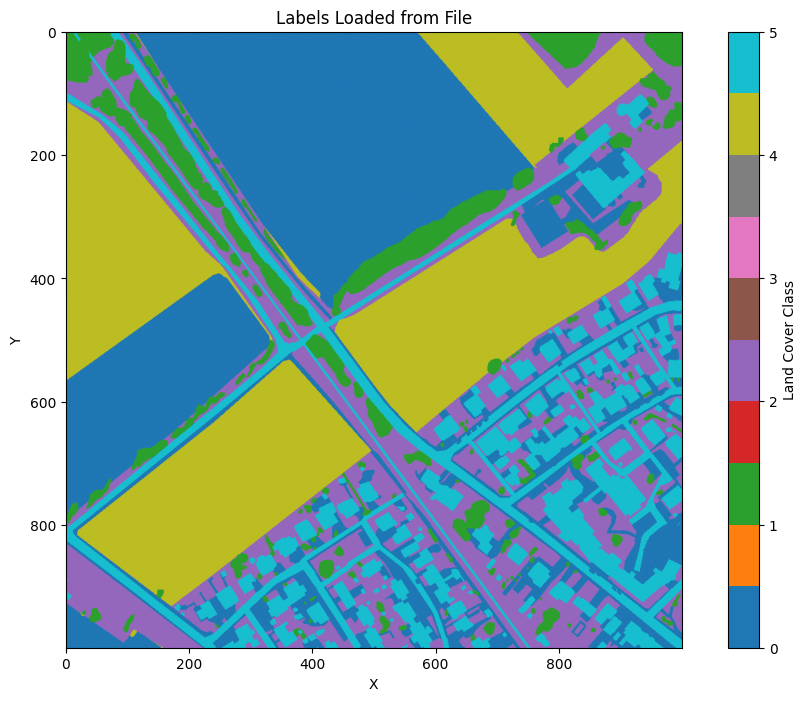

In [3]:
# ฟังก์ชันโหลดไฟล์ TIFF
def load_all_tiffs(folder_path):
    tiff_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]
    datasets = []
    for file_path in tiff_files:
        with rasterio.open(file_path) as src:
            data = src.read()
            profile = src.profile
            datasets.append((data, profile))
            print(f"Loaded {file_path}, Number of bands = {data.shape[0]}")
    return datasets

# ระบุ path ของโฟลเดอร์และไฟล์ Labels
folder_path = r"C:\Users\lucky\Desktop\traindata\New folder"  # Path ของโฟลเดอร์ที่มีไฟล์ TIFF
labels_path = r"C:\Users\lucky\Desktop\traindata\aachen_3.tif"  # Path ของไฟล์ Labels

# โหลดข้อมูล TIFF
datasets = load_all_tiffs(folder_path)

# โหลดไฟล์ Labels
with rasterio.open(labels_path) as src:
    labels = src.read(1)  # อ่านเฉพาะ Band 1 ของไฟล์ Labels

# แสดงผล Labels
plt.figure(figsize=(12, 8))
plt.imshow(labels, cmap='tab10', vmin=0, vmax=5)
plt.colorbar(ticks=[0, 1, 2, 3, 4, 5], label="Land Cover Class")
plt.title("Labels Loaded from File")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Features

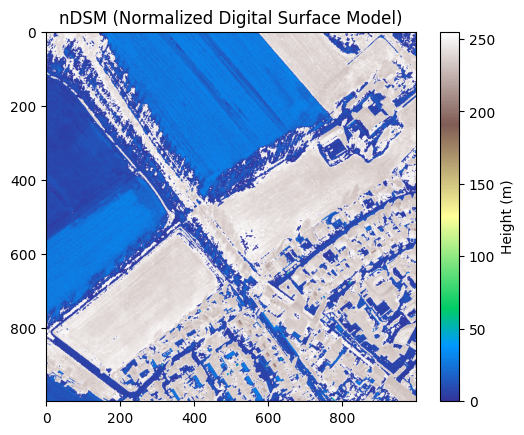

In [4]:
# ฟังก์ชันคำนวณ nDSM
def calculate_ndsm(dsm, dtm):
    return dsm - dtm

# โหลดข้อมูล DSM, DTM, และ Red Band
dsm = datasets[0][0][0]  # DSM: Band 1
dtm = datasets[0][0][1]  # DTM: Band 2
red_band = datasets[0][0][2]  # Red Band: Band 3

# คำนวณ nDSM
ndsm = calculate_ndsm(dsm, dtm)

# แสดงผล nDSM
plt.imshow(ndsm, cmap='terrain')
plt.colorbar(label='Height (m)')
plt.title('nDSM (Normalized Digital Surface Model)')
plt.show()


## คำนวณ Slope และ Aspect

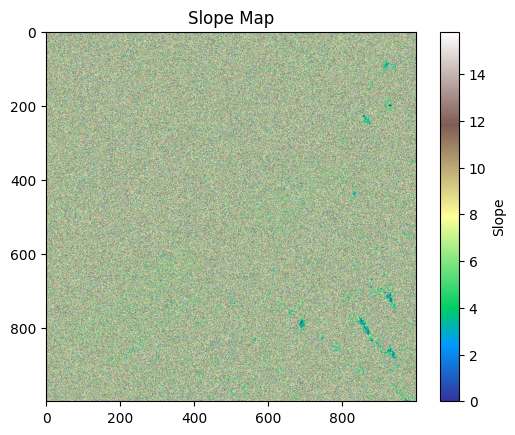

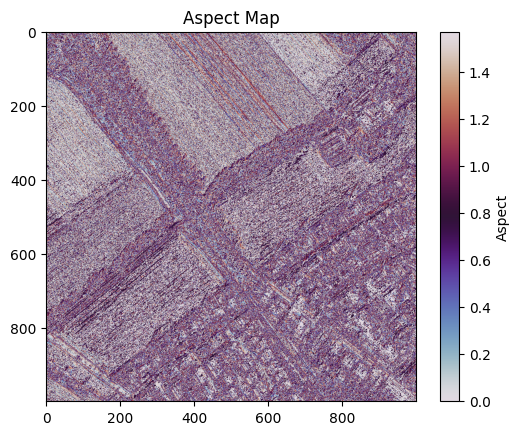

In [5]:
# ฟังก์ชันคำนวณ Slope และ Aspect
def calculate_slope_aspect(dsm):
    dx = sobel(dsm, axis=1)  # Gradient ตามแนวแกน X
    dy = sobel(dsm, axis=0)  # Gradient ตามแนวแกน Y
    slope = np.sqrt(dx**2 + dy**2)  # Slope
    aspect = np.arctan2(dy, dx)  # Aspect
    return slope, aspect

# คำนวณ Slope และ Aspect
slope, aspect = calculate_slope_aspect(dsm)

# แสดงผล Slope
plt.imshow(slope, cmap='terrain')
plt.colorbar(label='Slope')
plt.title('Slope Map')
plt.show()

# แสดงผล Aspect
plt.imshow(aspect, cmap='twilight')
plt.colorbar(label='Aspect')
plt.title('Aspect Map')
plt.show()


## คำนวณ Height Class (Tree, Building)

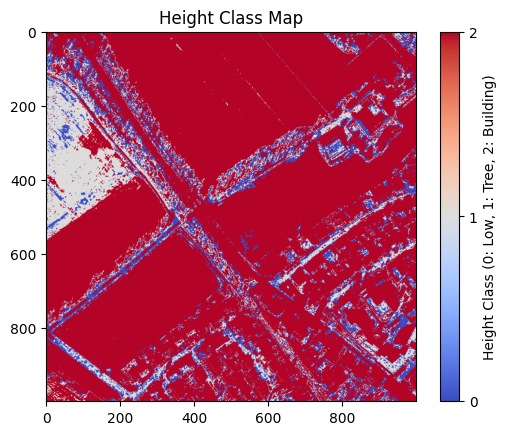

In [6]:
# ฟังก์ชันแยกประเภทความสูง
def calculate_height_class(ndsm):
    height_class = np.zeros_like(ndsm)
    height_class[(ndsm > 5) & (ndsm <= 10)] = 1  # Tree
    height_class[ndsm > 10] = 2  # Building
    return height_class

# คำนวณ Height Class
height_class = calculate_height_class(ndsm)

# แสดงผล Height Class
plt.imshow(height_class, cmap='coolwarm', vmin=0, vmax=2)
plt.colorbar(ticks=[0, 1, 2], label='Height Class (0: Low, 1: Tree, 2: Building)')
plt.title('Height Class Map')
plt.show()


## คำนวณ Edge Detection

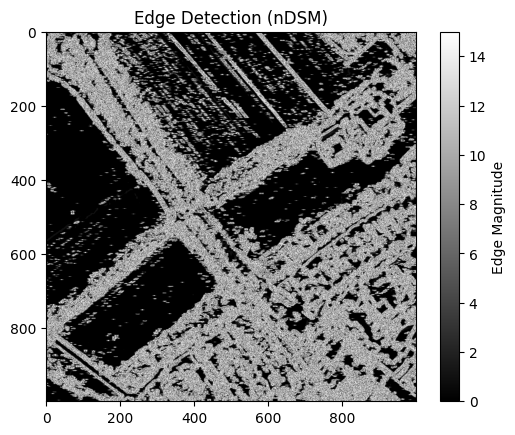

In [7]:
# คำนวณ Edge Detection จาก nDSM
edges = gaussian_gradient_magnitude(ndsm, sigma=2)

# แสดงผล Edge Detection
plt.imshow(edges, cmap='gray')
plt.colorbar(label='Edge Magnitude')
plt.title('Edge Detection (nDSM)')
plt.show()


## คำนวณ Vegetation Proxy

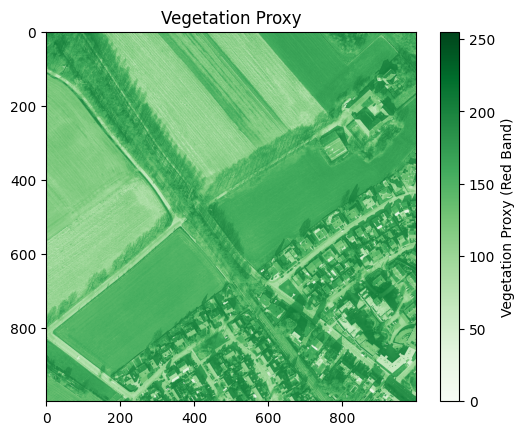

In [8]:
# สร้าง Vegetation Proxy
vegetation_proxy = 250 - red_band  # ยิ่งค่าต่ำ ยิ่งมีแนวโน้มเป็นพืชพรรณ

# แสดงผล Vegetation Proxy
plt.imshow(vegetation_proxy, cmap='Greens')
plt.colorbar(label='Vegetation Proxy (Red Band)')
plt.title('Vegetation Proxy')
plt.show()


## คำนวณ Local Mean และ Variance

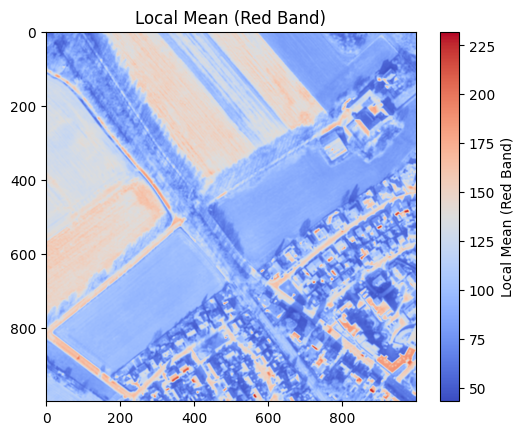

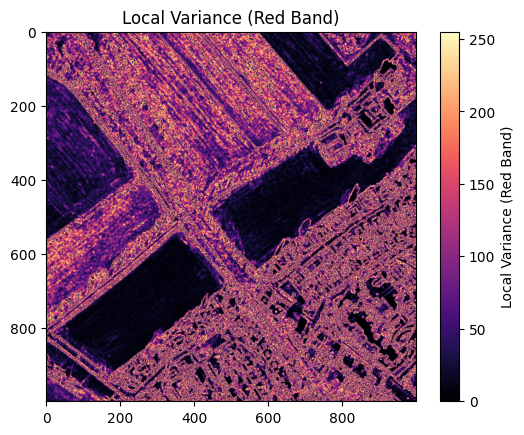

In [8]:
# ฟังก์ชันคำนวณ Local Mean และ Variance
def calculate_local_mean(image, size=5):
    return generic_filter(image, np.mean, size=size)

def calculate_local_variance(image, size=5):
    return generic_filter(image, np.var, size=size)

# คำนวณ Local Mean และ Variance ของ Red Band
local_mean = calculate_local_mean(red_band, size=5)
local_variance = calculate_local_variance(red_band, size=5)

# แสดงผล Local Mean
plt.imshow(local_mean, cmap='coolwarm')
plt.colorbar(label='Local Mean (Red Band)')
plt.title('Local Mean (Red Band)')
plt.show()

# แสดงผล Local Variance
plt.imshow(local_variance, cmap='magma')
plt.colorbar(label='Local Variance (Red Band)')
plt.title('Local Variance (Red Band)')
plt.show()


## เตรียมข้อมูลและใช้ SMOTE



In [9]:
# รวม Features: nDSM, Red Band, Slope, Aspect, Height Class, Edge Detection, Vegetation Proxy, Local Mean, Local Variance
X = np.stack([
    ndsm.flatten(),
    red_band.flatten(),
    slope.flatten(),
    aspect.flatten(),
    height_class.flatten(),
    edges.flatten(),
    vegetation_proxy.flatten(),
    local_mean.flatten(),
    local_variance.flatten()
], axis=1)

# Labels จากไฟล์
y = labels.flatten()


## เทรนโมเดล Random Forest และปรับ Hyperparameters

In [14]:
# Grid Search เพื่อปรับ Hyperparameters
param_grid = {
    'n_estimators': [100, 200],  # ลดจำนวนค่าที่ทดลอง
    'max_depth': [10, 20],      # ลดความลึกที่ทดลอง
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2]
}
    
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# ใช้โมเดลที่ดีที่สุด
best_rf = grid_search.best_estimator_


Fitting 2 folds for each of 16 candidates, totalling 32 fits


KeyboardInterrupt: 

In [ ]:
# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# เทรนโมเดลที่ดีที่สุด
best_rf.fit(X_train, y_train)

# ทำนายผล
y_pred = best_rf.predict(X_test)

# แสดงผลการประเมิน
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     93137
           1       0.53      0.19      0.28     22154
           2       0.46      0.77      0.58     57670
           4       0.88      0.89      0.89     80839
           5       0.61      0.35      0.44     20405
           6       0.92      0.19      0.32       340
           7       0.52      0.31      0.39     25455

    accuracy                           0.69    300000
   macro avg       0.67      0.49      0.52    300000
weighted avg       0.70      0.69      0.68    300000

Confusion Matrix:
[[70392   870 14777  1257  2607     0  3234]
 [ 1308  4231 15862   464    22     0   267]
 [ 4594  2453 44290  4860   282     3  1188]
 [ 1263   139  6865 72015   153     0   404]
 [ 4519   260  5596   903  7057     0  2070]
 [   40     0   130     1     3    66   100]
 [ 5335    91  8727  1909  1473     3  7917]]


In [ ]:
# ทำนายผลลัพธ์ทั้งหมด
classified_map = best_rf.predict(X).reshape(ndsm.shape)

# คำนวณเปอร์เซ็นต์ของแต่ละคลาส
unique, counts = np.unique(classified_map, return_counts=True)
total_pixels = classified_map.size
percentages = {f"Class {int(k)}": (v / total_pixels) * 100 for k, v in zip(unique, counts)}

# แสดงเปอร์เซ็นต์
print("Percentage of each class:")
for k, v in percentages.items():
    print(f"{k}: {v:.2f}%")


Percentage of each class:
Class 0: 29.16%
Class 1: 2.68%
Class 2: 32.12%
Class 4: 27.12%
Class 5: 3.83%
Class 6: 0.02%
Class 7: 5.07%


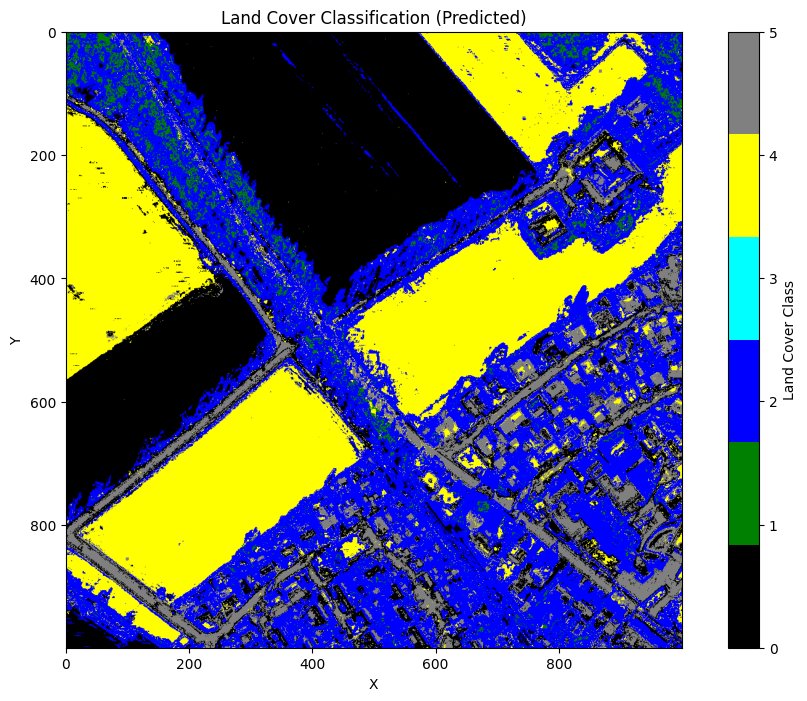

In [ ]:
# สีสำหรับแต่ละคลาส
colors = ["black", "green", "blue", "aqua", "yellow", "gray"]
cmap = plt.matplotlib.colors.ListedColormap(colors)

# พล็อตผลลัพธ์
plt.figure(figsize=(12, 8))
plt.imshow(classified_map, cmap=cmap, vmin=0, vmax=5)
plt.colorbar(ticks=[0, 1, 2, 3, 4, 5], label="Land Cover Class")
plt.title("Land Cover Classification (Predicted)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


# U model

In [42]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Expansive Path
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(6, 1, activation='softmax')(conv5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# สร้างโมเดล U-Net
model = unet_model(input_size=(256, 256, 3))
model.summary()


ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.